<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Projet AML</div>

<img src="Nom_projet.png" style="width:500px;height:110px"/>

1. [Introduction](#sec1)
2. [Les imports ](#sec2)
3. [Chargement des images et fonctions de visualisation](#sec3)
4. [Modèle VGG19](#sec4)
5. [Isolation du style et du contenu](#sec5)
6. [Creation du modèle](#sec6)
7. [Methode et calcul du style d'une image](#sec7)
8. [Descente de gradient et génération d'image](#sec8)
9. [Total variation loss](#sec9)
10. [Conlusion](#sec10)
11. [Sources](#sec11)

## <a id="sec1"></a>Introduction 

Dans les beaux-arts, en particulier la peinture, les humains ont maîtrisé la compétence pour créer des
des expériences visuelles en composant une interaction complexe entre le contenu et le style d'une image. <br>
Jusqu'à présent, la base algorithmique de ce processus est inconnue et il n’existe pas de système artificiel avec des capacités similaires. 

Cependant, dans d'autres domaines clés de la perception visuelle tels que la reconnaissance d'objets et de visages
la performance quasi humaine a été récemment rendue possible par une classe de
modèles de vision inspirés appelés Deep Neural Networks. <br> 

On veut maintenant réussir à isoler non seulement le contenu mais aussi le style d'une image (peinture d'un grand maitre par exemple).
C'est ce qu'on appelle le transfert de style. 

On pourrait vouloir utiliser une approche traditionnelle d'apprentissage supervisé, le transfert de style appris nécessite une paire d'images d'entrée - à la fois une image originale et une représentation artistique de cette image originale. À partir de là, un modèle d'apprentissage automatique apprend la transformation et peut l'appliquer à de nouvelles images originales.
Malheureusement, cette approche est vite limitée, car ces types de paires d'images existent rarement. 

<div class="alert alert-block alert-success">

Mais ces dernières années, une nouvelle approche, **le transfert de style neuronal (NST)**, a changé ce qui est possible.


NST utilise des réseaux de neurones profonds pour alimenter ces transformations. Les réseaux de neurones sont utilisés pour extraire les caractéristiques statistiques des images liées au contenu et au style afin que nous puissions quantifier le fonctionnement du transfert de style. 
**Avec cette approche améliorée, une seule image de référence de style est nécessaire pour que le réseau neuronal l'applique aux images de contenu d'origine.**

<div class="alert alert-block alert-info">

Cet article et le travail de recherche qui y a été mené offre une voie vers une compréhension algorithmique de la manière dont les humains créent et perçoivent l'imagerie artistique.


La technique mise en évidence dans cet article <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.) est maintenant très populaire. 
Elle est connue sous le nom de *neural style transfer*.

Ce n'est plus la methode la plus rapide ou la plus optimisée ([cyclegan](cyclegan.ipynb) est jusqu'à 1000 fois plus rapide) mais ce fut la methode pionnière en la matière. 
Nous allons l'explorer dans la suite de ce notebook. 

Le **neural style transfer** est une technique d'optimisation utilisée pour prendre deux images - une image de contenu et une image de référence de style (comme une illustration d'un peintre célèbre) - et les mélanger afin que l'image de sortie ressemble à l'image de contenu, mais «peinte» dans le style de l'image de référence de style.


<img src="Rsc/image.png" />
<div>
    A gauche l'image et à droite l'image reprise dans le style de  ***The Shipwreck of the Minotaur*** de J.M.W.
Turner, 1805

<div class="alert alert-block alert-info">
Pour mieux comprendre la methode, les explications théoriques suivront l'architecture du notebook permettant de mettre en oeuvre la methode 

## <a id="sec2"></a>Les imports 

Pas la partie la plus interessante mais il ne faut pas l'oublier 

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image 
import time
import functools
import base64
import io

## <a id="sec3"></a>Chargement des images et fonctions de visualisation

<div class="alert alert-block alert-success">

Dans cette partie nous allons simplement définir les fonctions qui nous seront ensuite utiles pour pouvoir traiter et visualiser les images (preprocessing et la visualisation des images au fur et à mesure). 
C'est une permière étape qui n'est pas le coeur du sujet, le code sera commenté mais il n'y aura pas d'explication théorique car les fonctions sont relativement simples. 

In [2]:
#Donner les chemins à des variables pour pouvoir ensuite les prepocess 
content_path = './images/seb-oui.jpg'
style_path = './images/femme.jpg'

In [3]:
#Une fonction importante pour la suite qui permet de visualiser les images en provenance de tenseurs 

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
# Une fonction pour plot les images 
# On a rajouté une option titre 

def imshow(image, title=None):
    # Pour etre sur que la dimension est bonne
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [70]:
#Une autre fonction pour plot les images 3 par 3 afin de plus facilement pouvoir comparer l'image de contenu 
#l'image de style et l'image résultant du mix 

def plot_images(content_image, mixed_image, style_image):
    # Division de l'image en 3 
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Application de cette methode pour l'affichage des 3 images une par une -> Contenu
    ax = axes.flat[0]
    if len(content_image.shape) > 3:
        image = tf.squeeze(content_image, axis=0)

    ax.imshow(image)
    ax.set_xlabel('content_image')

    # Mix
    ax = axes.flat[1]
    if len(mixed_image.shape) > 3:
        image = tf.squeeze(mixed_image, axis=0)

    ax.imshow(image)
    ax.set_xlabel('mixed_image')

    # Style
    ax = axes.flat[2]
    if len(style_image.shape) > 3:
        image = tf.squeeze(style_image, axis=0)

    ax.imshow(image)
    ax.set_xlabel('style_image')

    # On enlève les ticks des images 
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    # On affiche tout 
    plt.show()

In [71]:
# La fonction principale de la section, le chargement des images et la prétransformation:
#(on limite l'image à 512 pixels)

def load_img(chemin_image):
    max_dim = 512
    # Ouverture, lecture et conversion de l'image pour pouvoir travailler avec 
    img = tf.io.read_file(chemin_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # On normalise l'image aux 512 pixels que prend le modèle Vgg19 utilisé par la suite 
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    # On resize le tenseur de l'image pour qu'il soit exploitable 
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

<div class="alert alert-block alert-info">
Maintenant que toutes ces fonctions sont écrites, il est temps de tester leur bon fonctionnement

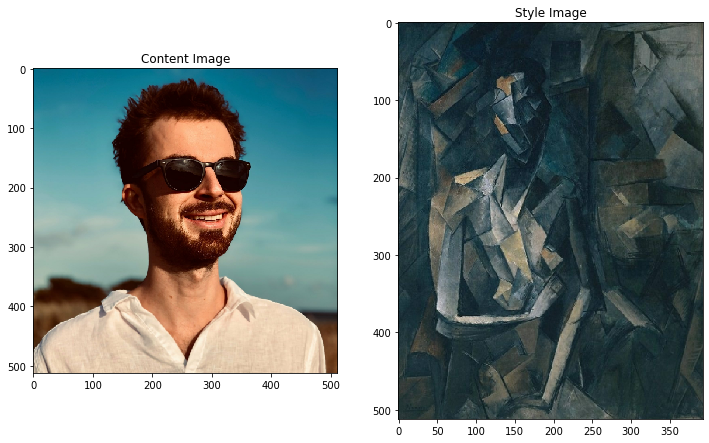

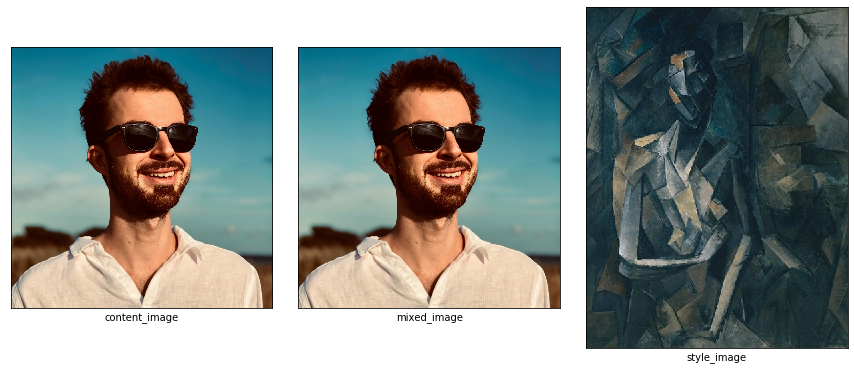

In [72]:
# On test le bon fonctionement de nos fonctions 
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#pour le moment la mixed image sera la content
plot_images(content_image,content_image,style_image)

## <a id="sec4"></a>Modèle VGG19 

### Rappels sur les CNN 

<div class="alert alert-block alert-info">
    
Les ConvNets fonctionnent sur le principe de base de **la convolution**. 
    
Disons, par exemple, que nous avons une image et un filtre. 
Nous glissons le filtre sur l'image et prenons en sortie, la somme pondérée des entrées couvertes par le filtre, transformées par une fonction non-linéaire telle que sigmoïde ou ReLU ou tanh. 
Chaque filtre a son propre ensemble de poids, qui ne changent pas pendant l'opération de convolution. 
Ceci est représenté dans le GIF ci-dessous-

<img src="Rsc/convolution.gif" align="center">

Ici, la grille bleue est l'entrée. Vous pouvez voir la région 3x3 couverte par la diapositive de filtre à travers l'entrée (région bleu foncé). Le résultat de cette convolution est appelé une carte de caractéristiques, qui est représentée par la grille de couleur verte.

Comme référence pour aller plus loin dans les réseau Convolutionnels (CNN) je vous propose un cours de stanford qui aborde toutes les notions inhérentes aux CNN en profondeur. 
https://cs231n.github.io/convolutional-networks/

<div class="alert alert-block alert-info">

Une autre transformation importante à avoir en tête pour comprendre l'achitecture VGG19 est la **transformation MaxPool**.
    
Elle est principalement utilisé à des fins de réduction de dimensionnalité. 
    
Dans une opération maxpool, nous faisons simplement glisser une fenêtre, disons de taille 2x2, sur l'image et prenons en sortie, le maximum de valeurs couvertes par la fenêtre. Voici un exemple


<img src="Rsc/maxpool.jpeg" align="center">

### Le modèle VGG19

La methode employée necessite un reseau de neuronne ayant une architecture lui permettant de réaliser de la reconnaissance d'image.
Nous allons utiliser l'architecture **[VGG19](https://keras.io/applications/#vgg19)** déjà construite dans Keras et pré-entrainée (ce qui va grandement accelerer le traitement) 

<img src="Rsc/vgg_19.jpeg" />
Architecture **VGG-19** avec le detail des différentes couches
Dans l'article le VGG-19 a été modifié en remplacant les max_pool par des average pool mais n'ayant pas ce modèle modifié pré-entrainé nous nous sommes ici limité au modèle classique

On va dans un premier temps tester le classifieurs entrainé basé sur VGG-19 pour être sur de son efficacité et de son pré-entrainement. 

In [11]:
# On charge le modèle VGG-19 

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [12]:
# On teste le classifieur sur notre image de contenu 
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
prediction_probabilities = vgg(x)
prediction_probabilities.shape
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

NameError: name 'content_image' is not defined

Normalement ce qui ressort de l'identification devrait être relativement concluant. J'ai réalisé pas mal d'essais (je joins mes images avec le dossier) qui démontrent l'efficacité de ce modèle 

## <a id="sec5"></a>Isolation du style et du contenu 

### Principe

#### Contenu

Toute la methode repose sur **l'identification et l'isolation du contenu de la content_image et du style de la style_image.** <br>
Lorsque les réseaux de neurones convolutionnels sont formés à la reconnaissance d'objets, ils développent une
représentation de l'image qui rend les informations d'objet de plus en plus explicites au fil du traitement.

Par conséquent, le long du traitement du réseau, l'image d'entrée se transforme en représentation qui se soucie de plus en plus du contenu réel plutot que des pixels détaillées. Nous pouvons visualiser directement les informations de chaque couche contient à propos de l'image d'entrée en reconstruisant l'image uniquement à partir de ces couches. 

Ce sont les couches supérieures du réseau qui capturent le contenu de haut niveau en termes d'objets et de disposition dans l'image d'entrée sans contraindre les valeurs de pixels exactes. Ce seront ces dernières qui nous interesseront pour la représentation du contenu. 

<img src="Rsc/image2.png" style="width:700px;height:500px"/>

#### Style

Pour obtenir une représentation du style d'une image d'entrée, nous utilisons un espace de fonctionnalités à l'origine
conçu pour **capturer les informations de texture**. Cet espace de fonctionnalités est construit à partir des réponses de filtre dans chaque couche du réseau. Il se compose des corrélations entre les différentes réponses du filtre
sur l'étendue spatiale des entités d'entrée. 

En incluant la fonctionnalité corrélations de plusieurs couches, nous obtenons une représentation stationnaire et multi-échelle de l'entrée image, qui capture ses informations de texture mais pas l'arrangement global.

Finalement on va récupérer les informations en ciblant les couches suivantes du reseau 
<img src="Rsc/vgg_19_2.jpg"/>

In [13]:
# pour se faire on va charger un reseau vgg qui sans sa tête classificatrice et on va lui faire afficher ses layers 

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Puis on va choisir les layers de travail 
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## <a id="sec6"></a>Creation du modèle 

In [76]:
# On crée un modèle à partir de vgg qui renvoie les valeurs à chaque couche pour le style (pour le moment)

def vgg_layers(layer_names):
    # On charge un vgg pré-entrainé 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    
    vgg.trainable = False
    # On lui récupère les sorties de chaque couche 
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [77]:
# On lance le modèle précédent et on récupère les données liées au style 
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#On peut maintenant facilement obtenir toutes les données et les statistiques couche par couche 
print('on a',len(style_outputs) ,'couches pour le style')
print('Et pour la première on a:')
output = style_outputs[0]
print(style_layers[0])
print("  shape: ", output.numpy().shape)
print("  min: ", output.numpy().min())
print("  max: ", output.numpy().max())
print("  mean: ", output.numpy().mean())

on a 5 couches pour le style
Et pour la première on a:
block1_conv1
  shape:  (1, 512, 393, 64)
  min:  0.0
  max:  694.9159
  mean:  12.355726


## <a id="sec7"></a>Methode et calcul du style d'une image 

<div class="alert alert-block alert-info">

Il est capital de pouvoir quantifier le style et le contenu d'une image; en effet, la methode repose sur une **minisation simultanée d'une loss fonction de style et de contenu**

#### Pour le contenu:

Chaque couche du réseau définit un banc de filtres non linéaire dont la complexité augmente avec la position de la couche dans le réseau. Par conséquent, une image d'entrée donnée x est codée dans chaque couche du CNN par les réponses du filtre à cette image. Une couche avec $N_{l}$ filtres distincts a des cartes de caractéristiques $N_{l}$ de taille $M_{l}$, où $M_{l}$ est la hauteur multipliée par la largeur de la carte des caractéristiques *(feature map)*.


Ainsi les réponses d'une couche l peuvent être stockées dans une matrice $F_{l} ∈ R^{N_{l} × M_{l}}$ où $F_{lij}$ est l'activation du ième filtre en position j dans la couche l. 
Pour visualiser les informations d'image encodées à différentes couches de la hiérarchie  nous effectuons une descente de gradient sur une image de bruit blanc pour trouver une autre image qui correspond aux réponses aux caractéristiques de l'image originale. 


<div class="alert alert-block alert-success">

Soit p et x l'image originale et l'image générée et $P_{l}$ et $F_{l}$ leur représentation des entités respectives dans la couche l. <br>
Nous définissons ***the squared error loss***:

<img src="Rsc/formule1.png" style="width:265px;height:55px"/>

#### Pour le style:

Une des nouveauté de l'articles est que le style d'une image peut être décrit par les moyens et les corrélations entre les différentes features des couches intermédiaires. 
À partir des matrices de Gram qui contiennent ces informations en prenant le produit externe du vecteur de caractéristiques avec lui-même à chaque emplacement et en calculant la moyenne de ce produit externe sur tous les emplacements. 

<div class="alert alert-block alert-success">

Cette matrice de Gram peut être calculée pour une couche particulière comme suit:
$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

In [78]:
# Avec tf.linalg.einsum on peut facilement coder la construction de cette matrice de gram 
# I et J sont les deux dimensions de la matrice Fl

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

On va maintenant construire un modèle qui renvoit la matrice de contenu pour représenter le contenu de l'image content et la matrice de gram de l'image style. 

In [79]:
class StyleContentModel(tf.keras.models.Model):
    
    # Pareil que dans le modèle précédent, lce modèle  renvoit les couches séléctionnées pour le style et le contenu 
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # les inputs sont entre 0 et 1 il faut donc les remultiplier 
        inputs = inputs*255.0
        # prepocess pour pouvoir les utiliser dans vgg19 (keras gère le prepprocessing lui-même)
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        # Récupération des données sorties par vgg19 pour les layers que on a selectionné
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        
        # Calcul des matrices de gram 

        style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

        # Récupération des matrices de contenu 
        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

        # Récupération des matrices de Gram 
        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [80]:
# On applique le modèle pour extraire à partir des images cibles les "objectifs" de style et de contenu maintenant 
# que ces denrniers sont quatifiés 
extracteur = StyleContentModel(style_layers, content_layers)

results = extracteur(tf.constant(content_image))

# Affichage de statistiques sur les résultats pour vérifier la cohérence 
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.014416417
    max:  25179.465
    mean:  552.332

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  57754.305
    mean:  10969.783

   block3_conv1
    shape:  (1, 256, 256)
    min:  1.0071968
    max:  239030.48
    mean:  10312.282

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1818762.0
    mean:  153441.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  102758.29
    mean:  1393.9685

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1431.9636
    mean:  13.001989


<div class="alert alert-block alert-info">

On a donc maintenant extrait une image quantifiée et chiffrée du style et du contenu de l'image 
La méthode repose maintenant sur une descente de gradient pour à partir d'un bruit blanc minimiser l'écart au contenu et au style simultanement pour une image générée. 
    
**Ces matrices de styles et de contenu quantifiées sont nos cibles**.

## <a id="sec8"></a> Descente de gradient et génération d'image 

<div class="alert alert-block alert-success">
Il faut dans un premier temps définir nos fonction loss qui représente les pertes par rapport au contenu et au style. 
Pour le contenu on va utiliser comme défini précedemment la ***squared error loss*** 
<img src="Rsc/formule1.png" style="width:265px;height:55px"/>

et pour le style on va utiliser 
<img src="Rsc/formule3.png" style="width:205px;height:65px"/>
<img src="Rsc/formule4.png" style="width:180px;height:60px"/>

ce qui nous donne comme fonction loss finale :
<img src="Rsc/formule5.png" style="width:350px;height:55px"/>

avec deux poids alpha et beta que nous allons définir par la suite par rapport aux résultats de l'article

#### Création de Variable 

In [81]:
#On extrait les deux cibles 
style_goal = extracteur(style_image)['style']
content_goal =  extracteur(content_image)['content']

# On crée la variable qui va devoir avoir la même taille que l'image de contenu 
# pour ne pas avoir de soucis lors de la descente de gradient 
image = tf.Variable(content_image)

# On maintient nos pixels entre 0 et 1 pour la normalisation 
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### On va créer une fonction d'optimisation 

In [82]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [83]:
# On définit aussi nos poids 
alpha = 1e-2
beta = 1e2

In [21]:
#Et la fonction de perte style/contenu 

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_goal[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= beta / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_goal[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= alpha / num_content_layers
    loss = style_loss + content_loss
    return loss

#### Definition du pas et de l'avance 

In [22]:
# On définit le pas en appliquant toutes les fonctions précédemment définies 
# le pas est une descente de gradient dans le sens minimisant simultanement le contenu et le style 

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # On récupère l'image et on obtient la valeur de la loss fonction 
        outputs = extracteur(image)
        loss = style_content_loss(outputs)
        # On determine le gradient 
        grad = tape.gradient(loss, image)
        # On optimise avec le gradient 
        opt.apply_gradients([(grad, image)])
        # On assigne à l'image la valeur de l'image maintenant modifiée 
        image.assign(clip_0_1(image))

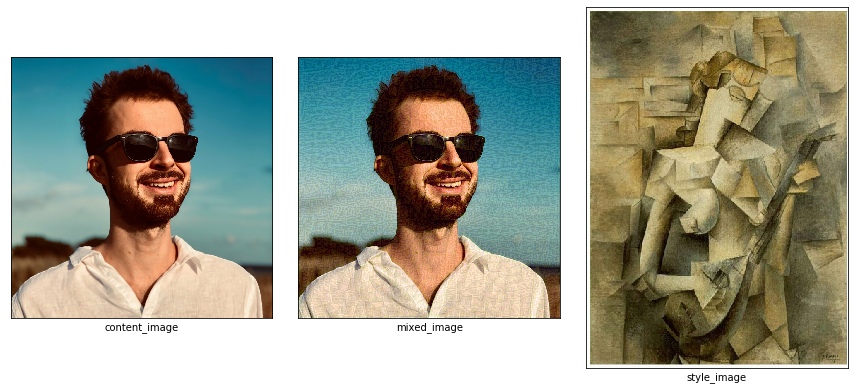

In [23]:
# On teste notre fonction avec plusieurs steps rapides avant de lancer véritablement une longue session 

train_step(image)
train_step(image)
train_step(image)
plot_images(content_image, image, style_image)

L'image commence à être transformée, on peut donc lancer plus d'étapes avec plusieurs époques pour avoir des visuels à chaque tiers de parcours 

In [ ]:
import time
start = time.time()

epochs = 3
steps_per_epoch = 30

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    print("Etape: {}".format(step))
    plot_images(content_image, image, style_image)

end = time.time()
print("Le temps d'execution a été : {:.1f}".format(end-start))
print("La dernière image est ainsi:")
display.display(tensor_to_image(image))

## <a id="sec9"></a>*Total variation loss*

Un dernier aspect à garder en tête lors de cette transformation est la notion de Total variation loss. 
Un inconvénient de cette implémentation de base est qu'elle produit de nombreuses erreurs en haute fréquence. 
Pour les limiter, il faut définir un terme de régularisation explicite sur les composantes haute fréquence de l'image. 

In [84]:
# Cette fonction permet de constater que la total variation n'est pas negligeable 
tf.image.total_variation(image).numpy()

array([19108.127], dtype=float32)

In [92]:
# On lui attribut un poids choisi empiriquement 
total_variation_weight = 30
alpha = 1e4
beta = 1e-2

In [93]:
# On crée une nouvelle loss function qui va prendre ne compte l'effet de la total variation loss 

def style_content_variation_loss(outputs, image):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_goal[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= beta / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_goal[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= alpha / num_content_layers
    loss = style_loss + content_loss + total_variation_weight*tf.image.total_variation(image)
    return loss

In [94]:
# On redéfini notre pas avec la nouvelle fonction loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extracteur(image)
        loss = style_content_variation_loss(outputs, image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

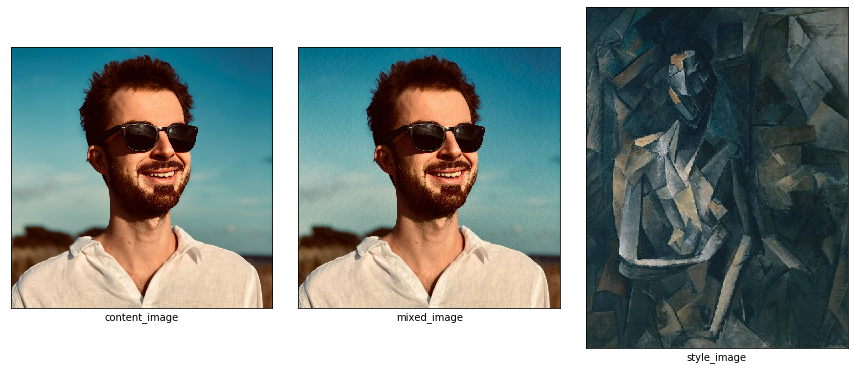

In [95]:
# On ré-initialise notre variable et on teste sur plusieurs étapes 
image = tf.Variable(content_image)
train_step(image)
train_step(image)
train_step(image)
plot_images(content_image, image, style_image)

....................................................................................................Etape: 100


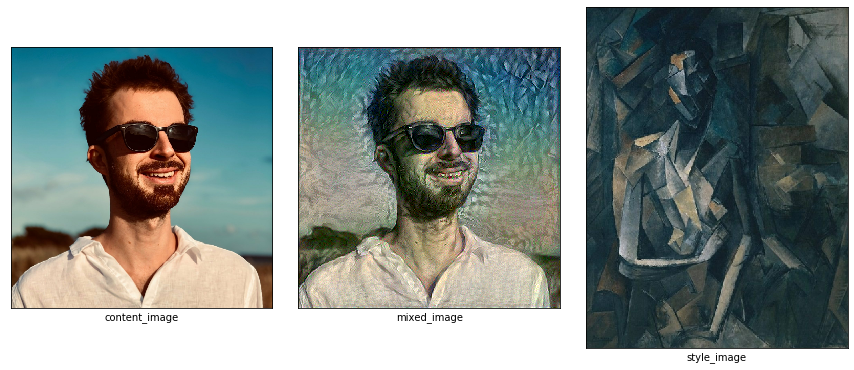

....................................................................................................Etape: 200


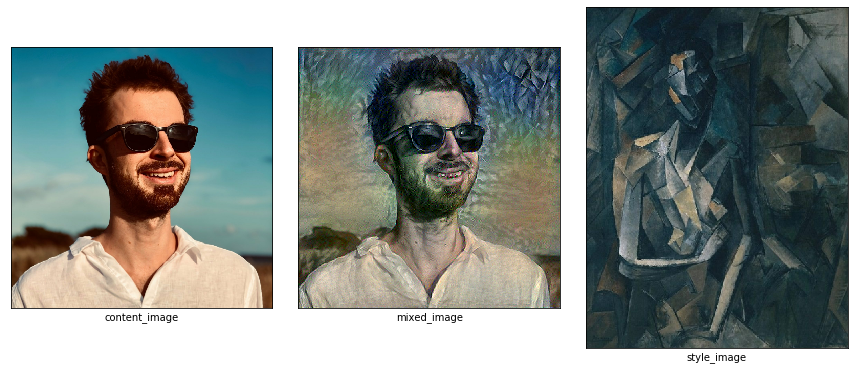

....................................................................................................Etape: 300


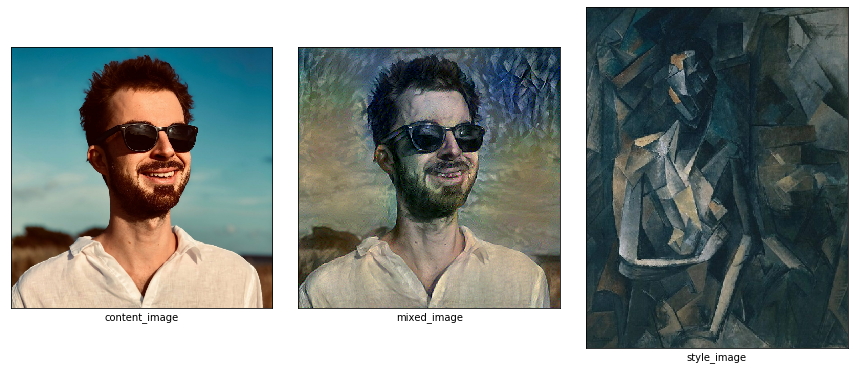

Le temps d'execution a été : 965.3
La dernière image est ainsi:


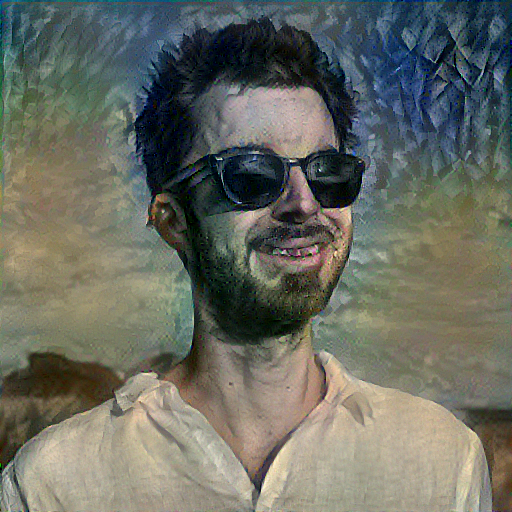

In [96]:
# Pour donner le temps d'execution on importe time que on lance au début de l'opération
import time
start = time.time()

# Par époque on définit le nombre d'étapes 
epochs = 3
steps_per_epoch = 100

# pour chaque étape on applique le step crée précédemment 
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    print("Etape: {}".format(step))
    # On plot à chauqe fois pour voir l'évolution 
    plot_images(content_image, image, style_image)

end = time.time()
print("Le temps d'execution a été : {:.1f}".format(end-start))
print("La dernière image est ainsi:")
display.display(tensor_to_image(image))

In [97]:
# On enregistre le résultat en executant la cellule suivante 
file_name = 'Image_générée2.png'
tensor_to_image(image).save(file_name)

In [98]:
# On constate l'effet sur la variation loss et on ajuste eventuellement le poids de la total variation en fonction 
tf.image.total_variation(image).numpy()

array([46326.258], dtype=float32)

## <a id="sec10"></a>Conclusion 

<div class="alert alert-block alert-info">

L'article que nous utilisons comme base pour notre étude ici a ouvert la voie pour tout un pan d'applications et de recherches subséquentes. 

Seulement quelques mois suite à sa publication, une application appelée *Prisma* a été publiée et elle a rencontré un succès fou. 
Au cas où vous ne savez pas ce qu'est Prisma, il s'agit essentiellement d'une application qui vous permet d'appliquer des styles de peinture de peintres célèbres à vos propres photos, et les résultats sont visuellement très agréables. Ce n'est pas comme les filtres Instagram, où une sorte de transformation est appliquée à l'image uniquement dans l'espace colorimétrique. C'est beaucoup plus élaboré et les résultats sont encore plus intéressants.

Cette methode à par la suite permis de créer des application encore plus interessantes nottament avec l'amélioration de la vitesse. 
En 2017, Google AI a introduit une méthode qui permet à un seul réseau de transfert convolutionnel profond d'apprendre plusieurs styles en même temps. Cet algorithme permet l'interpolation de style en temps réel, même lorsqu'elle est effectuée sur des supports vidéo.


Depuis un article de Fei-Fei Li a mis en évidence une autre methode de calcul de la loss et une méthode accélérée pour la formation afin de produire des résultats en temps réel (trois fois plus rapidement que Gatys). Leur idée était d'utiliser non pas la perte basée sur les pixels définie ci-dessus, mais plutôt une «perte de perception» mesurant les différences entre les couches de niveau supérieur au sein du CNN. 
Une fois formé, le réseau peut être utilisé pour transformer une image dans le style utilisé lors de la formation, en utilisant une seule passe d'anticipation du réseau. Cependant, le réseau est limité au seul style dans lequel il a été formé.

Un travail de Chen Dongdong explore la fusion des informations de flux optique dans des réseaux à action directe afin d'améliorer la cohérence temporelle de la sortie.

Plus récemment, des méthodes NST basées sur la transformation de fonctionnalités ont été explorées pour une stylisation rapide qui ne sont pas associées à un style spécifique unique et permettent un mélange de styles contrôlable par l'utilisateur, par exemple la *Whitening and Coloring Transform (WCT)*


Je met ici le lien vers une utilisation en vidéo pour montrer l'amélioration de l'immersion avec l'utilisation de ce genre de methode. 
https://www.youtube.com/watch?v=pkgMUfNeUCQ&feature=emb_logo&ab_channel=ComputerVisionFreiburg

## <a id="sec11"></a>Sources

- https://arxiv.org/pdf/1508.06576.pdf
- https://towardsdatascience.com/neural-style-transfer-using-vgg-model-ff0f9757aafc
- https://github.com/darshanadakane/neuralStyleTransfer_usingVGG
- https://www.tensorflow.org/tutorials/generative/style_transfer